In [1]:
import pandas as pd
import numpy as np
import copy
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
curr_dir = os.getcwd()
data_folder = os.path.join(curr_dir, "CT15Mn-111018-150419", "dados_camara.csv")
dataset = pd.read_csv(data_folder)
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\CT15Mn-150818_101018\\dados_camara.csv")#dados mais recentes
#tomtom = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\tomtom_data.csv")
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\periodic_data.csv") #dados periodicos gerados automaticamente
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\dados_old.csv") #dados mais antigos
dataset['unique_id'] = dataset.Zona.astype(str) + '_' + dataset.ID_Espira.astype(str)
dataset['unique_id'] = dataset['unique_id'].str.lower()
dataset_uid = dataset[(dataset["unique_id"] == "22_ct5")]

dataset_uid = dataset_uid.drop(columns=["Zona","Contadores","ID_Espira","unique_id"])
dt2 = copy.deepcopy(dataset_uid)
#dataset.sort_values(['Data'],ascending=True).groupby('Data').reset_index()

dataset_uid = dataset_uid.groupby('Data').apply(lambda x: x.reset_index())

msk = np.random.rand(len(dataset_uid)) < 0.7
train_df = dataset_uid[msk]
test_df = dataset_uid[~msk]





dt2.to_csv("limited_data.csv", sep= ',', index=False)
#train_set
train_df = train_df.drop(columns=["index"])

train_df.to_csv("train.csv", sep= ',', index=False)

#test_set
test_df = test_df.drop(columns=["index"])
test_df.to_csv("test.csv", sep= ',', index=False)

#full set
dataset_uid = dataset_uid.drop(columns=["index"])
dataset_uid.to_csv("dados_nn.csv", sep=',', index=False)



In [44]:
#espira confluente (opcional)
#cmp= espira complementar
cmp_data = dataset[(dataset["unique_id"] == "22_ct2")]
cmp_data = cmp_data.drop(columns=["Zona","Contadores","ID_Espira","unique_id"])
train_cmp_data = cmp_data[cmp_data["Data"].isin(train_df["Data"])]
train_cmp_data = train_cmp_data.groupby('Data').apply(lambda x: x.reset_index())
train_cmp_data = train_cmp_data.drop(columns=["index"])

train_cmp_data.to_csv("train_cmp.csv", sep= ',', index=False)


test_cmp_data = cmp_data[cmp_data["Data"].isin(test_df["Data"])]
test_cmp_data = test_cmp_data.groupby('Data').apply(lambda x: x.reset_index())
test_cmp_data = test_cmp_data.drop(columns=["index"])

test_cmp_data.to_csv("test_cmp.csv", sep= ',', index=False)
#print(cmp_data)

In [45]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
hours = [dt.strftime('%H:%M') for dt in datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), timedelta(minutes=15))]

In [51]:
#smoothing using std_dev and mean
from scipy import stats
import statistics


import numpy as np

train_cp = copy.deepcopy(train_df)
test_cp = copy.deepcopy(test_df)

def smooth_data(train_cp,filename):
    data = train_cp.iloc[:,0]
    print(len(data.values))
    train_cp = train_cp.drop(columns=["Data"])
    train_cp = train_cp.values

    #train_cp = train_cp.astype('float32')

    avg_list = []
    std_list = []
    for i in range(len(train_cp[0])):
        curr_avg = sum(train_cp[:,i])/len(train_cp[:,i])
        avg_list.append(curr_avg)
        std_list.append(statistics.stdev(train_cp[:,i]))
    #FIX sera que e preciso guardar os valores antigos e usá-los para fazer os updates? 
    #agora esta a fazer uma especie de moving average, utilizando os valores novos nos updates seguintes


    
    for row in range(len(train_cp)):
        number_of_changes= 0
        for column in range(len(train_cp[0])):
            if (train_cp[row][column] > (avg_list[column] + 2*std_list[column])):
                old_value = train_cp[row][column]
                if column == 0:
                    previous_t = train_cp[row,-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                if column == 95:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,0]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                else:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                new_value = train_cp[row][column]
        print("Number of changes: " + str(number_of_changes))
                
    new_d = data.values.reshape(len(data.values),1)
    test = np.concatenate((new_d,train_cp),axis=1)
    pd.DataFrame(test).to_csv(str(filename) + ".csv", sep=',', index=False)
    return test, train_cp
smooth_train, df_train= smooth_data(train_cp, "train_2")
smooth_test, df_test = smooth_data(test_cp, "test_2")


train_cmp_cp = copy.deepcopy(train_cmp_data)
test_cmp_cp = copy.deepcopy(test_cmp_data)

smooth_train_cmp, df_train_cmp= smooth_data(train_cmp_cp, "train_cmp_2")
smooth_test_cmp, df_test_cmp= smooth_data(test_cmp_cp, "test_cmp_2")


120
Number of changes: 18
Number of changes: 12
Number of changes: 9
Number of changes: 12
Number of changes: 8
Number of changes: 6
Number of changes: 4
Number of changes: 7
Number of changes: 5
Number of changes: 10
Number of changes: 9
Number of changes: 4
Number of changes: 7
Number of changes: 3
Number of changes: 8
Number of changes: 7
Number of changes: 10
Number of changes: 6
Number of changes: 1
Number of changes: 0
Number of changes: 3
Number of changes: 3
Number of changes: 1
Number of changes: 3
Number of changes: 1
Number of changes: 1
Number of changes: 2
Number of changes: 0
Number of changes: 1
Number of changes: 4
Number of changes: 0
Number of changes: 0
Number of changes: 3
Number of changes: 3
Number of changes: 6
Number of changes: 0
Number of changes: 2
Number of changes: 1
Number of changes: 0
Number of changes: 0
Number of changes: 0
Number of changes: 4
Number of changes: 0
Number of changes: 0
Number of changes: 1
Number of changes: 5
Number of changes: 4
Numb

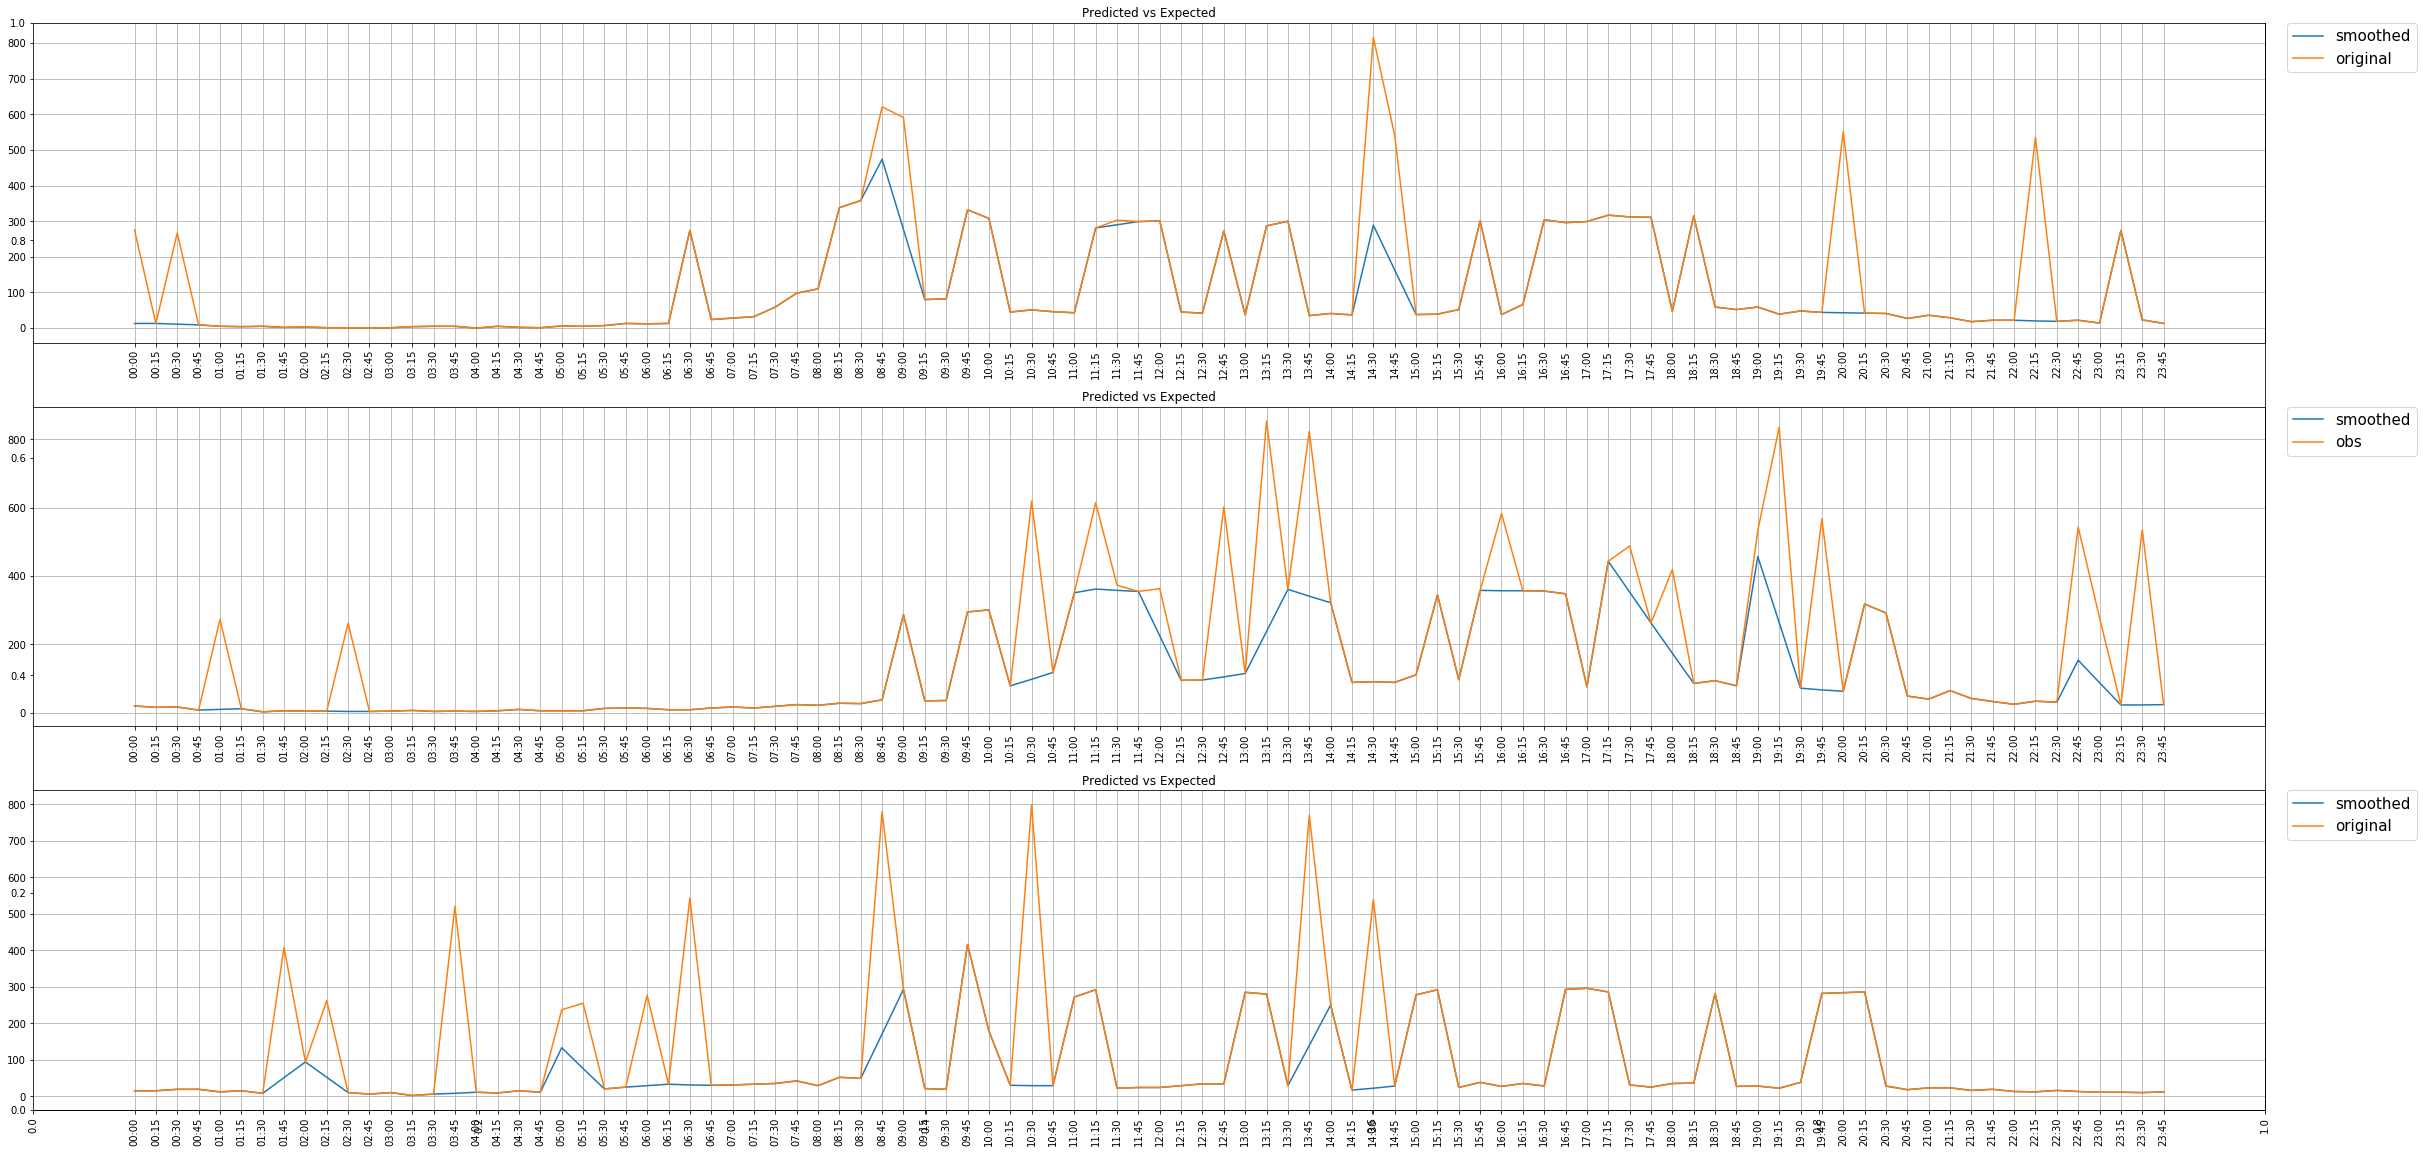

In [52]:
hours = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]


dataframe = pd.read_csv('train.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
train = dataset.astype('float32')

dataframe = pd.read_csv('test.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
test = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
train_cmp = dataset.astype('float32')

def plot_changes(original, smooth):
    fig = plt.figure(2)

    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(hours,smooth[0], label="smoothed")
    ax.plot(hours,original[0], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(312)
    ax.plot(hours,smooth[1], label="smoothed")
    ax.plot(hours,original[1], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(313)
    ax.plot(hours,smooth[2], label="smoothed")
    ax.plot(hours,original[2], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\smoothing\\" +"avg_2stdev_cmp.png", dpi=200)
plot_changes(train_cmp, df_train_cmp)

In [62]:
def transform_data(in_file, out_file, nrows=-1):
    in_file = open(str(in_file),"r")
    next(in_file)
    out_file = open(str(out_file),"w")
    out_file.write("t-3,t-2,t-1,Y\n") #header
    k = 0    
    lines = in_file.readlines()
    for line in lines:
        line = line.split(",")
        line = line[1:]
        line[-1] = line[-1].replace("\n","") #last data record has a \n
        its = [iter(line), iter(line[1:]), iter(line[2:]),iter(line[3:])] #Construct the pattern for longer windowss
        x = list(zip(*its))
        if (k == nrows):
            break
            
        k+=1 
#print(x)
    #j = 0
    #while(j<50): #this cycle was for creating a mock dataset with repeated data for testing purposes
        for i in x:
        #print(i[0],i[1],i[2],i[3])
            out_file.write(i[0] + "," + i[1] +"," + i[2] +","+ i[3])
            out_file.write("\n")
     #   j+=1
    
    in_file.close()
    out_file.close()
transform_data("dados_nn.csv", "new_f.csv")
transform_data("dados_nn.csv", "3day_nn.csv", 3)
transform_data("test_2.csv", "test_formatted.csv")
transform_data("test_2.csv", "3day_unsmoothed.csv",3)
transform_data("train_2.csv", "train_formatted.csv")
transform_data("train_cmp_2.csv", "train_cmp_formatted.csv")
transform_data("train_cmp.csv", "train_cmp_nosmooth.csv")

transform_data("test_cmp_2.csv", "test_cmp_formatted.csv")


In [2]:
def create_dataset2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# load the dataset
dataframe = pd.read_csv('freeway_data1.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
f_trainX, f_trainY = create_dataset2(train,3)
f_testX, f_testY =create_dataset2(test,3)


8104 3992


In [65]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import sys

# fix random seed for reproducibility
#numpy.random.seed(7)

#dataframe = pd.read_csv('new_f.csv') #raw data
#dataset = dataframe.values
#dataset = dataset.astype('float32')
#dataframe = pd.read_csv('test.csv') #data generated by reusing the same day 50 times


dataframe = pd.read_csv('train_formatted.csv')
dataset = dataframe.values
train_set = dataset.astype('float32')

dataframe = pd.read_csv('test_formatted.csv')
dataset = dataframe.values
test_set = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp_formatted.csv')
dataset = dataframe.values
train_cmp_set = dataset.astype('float32')

dataframe = pd.read_csv('test_cmp_formatted.csv')
dataset = dataframe.values
test_cmp_set = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp_nosmooth.csv')
dataset = dataframe.values
no_smooth = dataset.astype('float32')


def create_dataset(data):
    X,Y = [],[]
    for i in data:
        X.append(i[:3])
        Y.append(i[3])
    return numpy.array(X), numpy.array(Y)
print(len(train_set))
print(len(test_set))
print(len(train_cmp_set))
trainX, trainY = create_dataset(train_set)

testX, testY = create_dataset(test_set)
trainX_cmp,trainY_cmp = create_dataset(train_cmp_set)

print(trainX)
print(trainX_cmp)

trainX_both = np.concatenate((trainX, trainX_cmp), axis=1)
print(trainX_both)

11160
4092
11160
[[ 42. 290. 162.]
 [290. 162.  35.]
 [162.  35.  22.]
 ...
 [262. 212. 119.]
 [212. 119.  26.]
 [119.  26. 425.]]
[[13. 13. 11.]
 [13. 11.  9.]
 [11.  9.  5.]
 ...
 [11. 15. 11.]
 [15. 11. 11.]
 [11. 11.  8.]]
[[ 42. 290. 162.  13.  13.  11.]
 [290. 162.  35.  13.  11.   9.]
 [162.  35.  22.  11.   9.   5.]
 ...
 [262. 212. 119.  11.  15.  11.]
 [212. 119.  26.  15.  11.  11.]
 [119.  26. 425.  11.  11.   8.]]


In [5]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import sys


model = Sequential()
layer1 = Dense(32,input_dim=3, activation='relu')
layer2 = Dense(32, activation='relu')
layer3 = Dense(32, activation='relu')
#layer3 = Dense(400, activation='relu')
model.add(layer1)
model.add(layer2)
model.add(layer3)
#model.add(Dense(8, activation='relu'))
model.add(Dense(1))
sgd = optimizers.SGD(lr=0.001)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=rmsprop,metrics=['mape', 'mae', 'mse'])
model.fit(f_trainX, f_trainY, epochs=700, verbose=1)

W0716 18:02:23.090136 140367398831936 deprecation_wrapper.py:119] From /home/vasco/anaconda3/envs/tese/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0716 18:02:23.097682 140367398831936 deprecation_wrapper.py:119] From /home/vasco/anaconda3/envs/tese/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/700
8100/8100 [==============================] - 3s 377us/step - loss: 46347.2157 - mean_absolute_percentage_error: 18.0173 - mean_absolute_error: 107.2920 - mean_squared_error: 46347.2157
Epoch 2/700
8100/8100 [==============================] - 1s 93us/step - loss: 8206.3316 - mean_absolute_percentage_error: 11.7651 - mean_absolute_error: 60.8678 - mean_squared_error: 8206.3316
Epoch 3/700
8100/8100 [==============================] - 1s 92us/step - loss: 8073.3844 - mean_absolute_percentage_error: 11.6942 - mean_absolute_error: 60.2513 - mean_squared_error: 8073.3844
Epoch 4/700
8100/8100 [==============================] - 1s 94us/step - loss: 8009.6498 - mean_absolute_percentage_error: 11.6210 - mean_absolute_error: 60.0115 - mean_squared_error: 8009.6498
Epoch 5/700
8100/8100 [==============================] - 1s 107us/step - loss: 8036.7750 - mean_absolute_percentage_error: 11.6366 - mean_absolute_error: 59.9822 - mean_squared_error: 8036.7750
Epoch 6/700
8100/8100 [=======

8100/8100 [==============================] - 1s 77us/step - loss: 7856.0393 - mean_absolute_percentage_error: 11.8337 - mean_absolute_error: 59.1716 - mean_squared_error: 7856.0393
Epoch 44/700
8100/8100 [==============================] - 1s 76us/step - loss: 7920.8485 - mean_absolute_percentage_error: 11.8911 - mean_absolute_error: 59.7246 - mean_squared_error: 7920.8485
Epoch 45/700
8100/8100 [==============================] - 1s 76us/step - loss: 8015.1686 - mean_absolute_percentage_error: 11.8249 - mean_absolute_error: 59.3034 - mean_squared_error: 8015.1686
Epoch 46/700
8100/8100 [==============================] - 1s 77us/step - loss: 8030.8046 - mean_absolute_percentage_error: 11.8445 - mean_absolute_error: 59.8322 - mean_squared_error: 8030.8046
Epoch 47/700
8100/8100 [==============================] - 1s 78us/step - loss: 7924.4621 - mean_absolute_percentage_error: 11.8810 - mean_absolute_error: 59.4264 - mean_squared_error: 7924.4621
Epoch 48/700
8100/8100 [===================

8100/8100 [==============================] - 1s 80us/step - loss: 13509.0675 - mean_absolute_percentage_error: 14.0260 - mean_absolute_error: 78.7123 - mean_squared_error: 13509.0675
Epoch 86/700
8100/8100 [==============================] - 1s 74us/step - loss: 14464.0776 - mean_absolute_percentage_error: 14.2781 - mean_absolute_error: 80.2929 - mean_squared_error: 14464.0776
Epoch 87/700
8100/8100 [==============================] - 1s 78us/step - loss: 15553.6526 - mean_absolute_percentage_error: 14.5076 - mean_absolute_error: 83.1786 - mean_squared_error: 15553.6526
Epoch 88/700
8100/8100 [==============================] - 1s 80us/step - loss: 16806.3280 - mean_absolute_percentage_error: 14.9043 - mean_absolute_error: 85.9085 - mean_squared_error: 16806.3280
Epoch 89/700
8100/8100 [==============================] - 1s 75us/step - loss: 18850.9080 - mean_absolute_percentage_error: 15.5925 - mean_absolute_error: 91.6814 - mean_squared_error: 18850.9080
Epoch 90/700
8100/8100 [=========

8100/8100 [==============================] - 1s 80us/step - loss: 135843665.0810 - mean_absolute_percentage_error: 816.3538 - mean_absolute_error: 5860.0681 - mean_squared_error: 135843665.0810
Epoch 126/700
8100/8100 [==============================] - 1s 76us/step - loss: 157010038.6792 - mean_absolute_percentage_error: 943.4254 - mean_absolute_error: 6781.5246 - mean_squared_error: 157010038.6792
Epoch 127/700
8100/8100 [==============================] - 1s 76us/step - loss: 186612703.5193 - mean_absolute_percentage_error: 1064.6082 - mean_absolute_error: 7531.3266 - mean_squared_error: 186612703.5193
Epoch 128/700
8100/8100 [==============================] - 1s 75us/step - loss: 197846619.6676 - mean_absolute_percentage_error: 1163.5473 - mean_absolute_error: 8307.7749 - mean_squared_error: 197846619.6676
Epoch 129/700
8100/8100 [==============================] - 1s 75us/step - loss: 238417761.3161 - mean_absolute_percentage_error: 1195.1974 - mean_absolute_error: 8473.6429 - mean_s

8100/8100 [==============================] - 1s 72us/step - loss: 14675242137.8924 - mean_absolute_percentage_error: 9851.6128 - mean_absolute_error: 70584.7743 - mean_squared_error: 14675242137.8924
Epoch 164/700
8100/8100 [==============================] - 1s 72us/step - loss: 16021085040.8084 - mean_absolute_percentage_error: 7415.4226 - mean_absolute_error: 54369.4515 - mean_squared_error: 16021085040.8084
Epoch 165/700
8100/8100 [==============================] - 1s 77us/step - loss: 17031915584.1966 - mean_absolute_percentage_error: 8832.8725 - mean_absolute_error: 63433.4287 - mean_squared_error: 17031915584.1966
Epoch 166/700
8100/8100 [==============================] - 1s 73us/step - loss: 20220705152.5909 - mean_absolute_percentage_error: 8984.6710 - mean_absolute_error: 65484.9930 - mean_squared_error: 20220705152.5909
Epoch 167/700
8100/8100 [==============================] - 1s 68us/step - loss: 21736072121.5836 - mean_absolute_percentage_error: 10342.3122 - mean_absolute_

8100/8100 [==============================] - 1s 80us/step - loss: 302894608000.8218 - mean_absolute_percentage_error: 48732.2671 - mean_absolute_error: 344238.5499 - mean_squared_error: 302894608000.8218
Epoch 201/700
8100/8100 [==============================] - 1s 88us/step - loss: 334748820033.9746 - mean_absolute_percentage_error: 40032.4101 - mean_absolute_error: 287113.1974 - mean_squared_error: 334748820033.9746
Epoch 202/700
8100/8100 [==============================] - 1s 79us/step - loss: 344419950404.8882 - mean_absolute_percentage_error: 43713.7930 - mean_absolute_error: 313372.1083 - mean_squared_error: 344419950404.8882
Epoch 203/700
8100/8100 [==============================] - 1s 78us/step - loss: 390374600511.1379 - mean_absolute_percentage_error: 50071.8430 - mean_absolute_error: 356874.7182 - mean_squared_error: 390374600511.1379
Epoch 204/700
8100/8100 [==============================] - 1s 82us/step - loss: 401388093400.4483 - mean_absolute_percentage_error: 47213.8485

8100/8100 [==============================] - 1s 96us/step - loss: 4378820195435.1562 - mean_absolute_percentage_error: 125104.9178 - mean_absolute_error: 904606.0483 - mean_squared_error: 4378820195435.1562
Epoch 238/700
8100/8100 [==============================] - 1s 89us/step - loss: 4561911708143.2266 - mean_absolute_percentage_error: 159137.7099 - mean_absolute_error: 1130122.8939 - mean_squared_error: 4561911708143.2266
Epoch 239/700
8100/8100 [==============================] - 1s 118us/step - loss: 4881089853492.7041 - mean_absolute_percentage_error: 157038.3918 - mean_absolute_error: 1128360.3294 - mean_squared_error: 4881089853492.7041
Epoch 240/700
8100/8100 [==============================] - 1s 87us/step - loss: 5256917042943.0400 - mean_absolute_percentage_error: 151871.9974 - mean_absolute_error: 1109848.9610 - mean_squared_error: 5256917042943.0400
Epoch 241/700
8100/8100 [==============================] - 1s 91us/step - loss: 5336041554137.8398 - mean_absolute_percentage_

8100/8100 [==============================] - 1s 65us/step - loss: 26958829721067.1484 - mean_absolute_percentage_error: 394132.5593 - mean_absolute_error: 2799170.5279 - mean_squared_error: 26958829721067.1484
Epoch 274/700
8100/8100 [==============================] - 1s 71us/step - loss: 27893499193077.2188 - mean_absolute_percentage_error: 346035.2003 - mean_absolute_error: 2506157.8770 - mean_squared_error: 27893499193077.2188
Epoch 275/700
8100/8100 [==============================] - 1s 68us/step - loss: 28238355579916.6055 - mean_absolute_percentage_error: 391680.5134 - mean_absolute_error: 2759679.5920 - mean_squared_error: 28238355579916.6055
Epoch 276/700
8100/8100 [==============================] - 1s 66us/step - loss: 30507512882878.6836 - mean_absolute_percentage_error: 435221.8800 - mean_absolute_error: 3086978.9966 - mean_squared_error: 30507512882878.6836
Epoch 277/700
8100/8100 [==============================] - 1s 66us/step - loss: 32534648272601.2500 - mean_absolute_pe

8100/8100 [==============================] - 0s 60us/step - loss: 104944295220502.1719 - mean_absolute_percentage_error: 501798.9525 - mean_absolute_error: 3654685.6657 - mean_squared_error: 104944295220502.1719
Epoch 310/700
8100/8100 [==============================] - 1s 92us/step - loss: 111956169288119.3594 - mean_absolute_percentage_error: 648112.3129 - mean_absolute_error: 4697606.1933 - mean_squared_error: 111956169288119.3594
Epoch 311/700
8100/8100 [==============================] - 1s 99us/step - loss: 121765582302989.3750 - mean_absolute_percentage_error: 693198.1239 - mean_absolute_error: 5040802.3122 - mean_squared_error: 121765582302989.3750
Epoch 312/700
8100/8100 [==============================] - 1s 80us/step - loss: 124493512408136.5469 - mean_absolute_percentage_error: 856286.9826 - mean_absolute_error: 6094768.1583 - mean_squared_error: 124493512408136.5469
Epoch 313/700
8100/8100 [==============================] - 1s 72us/step - loss: 123899048871493.3906 - mean_ab

8100/8100 [==============================] - 1s 73us/step - loss: 379518644486216.5625 - mean_absolute_percentage_error: 1446742.7418 - mean_absolute_error: 10266926.6775 - mean_squared_error: 379518644486216.5625
Epoch 346/700
8100/8100 [==============================] - 1s 69us/step - loss: 370735347252846.4375 - mean_absolute_percentage_error: 1336634.3883 - mean_absolute_error: 9547445.9115 - mean_squared_error: 370735347252846.4375
Epoch 347/700
8100/8100 [==============================] - 1s 64us/step - loss: 381374485023642.6875 - mean_absolute_percentage_error: 1431368.0534 - mean_absolute_error: 10211475.4114 - mean_squared_error: 381374485023642.6875
Epoch 348/700
8100/8100 [==============================] - 1s 69us/step - loss: 424578580819751.5625 - mean_absolute_percentage_error: 1700750.2227 - mean_absolute_error: 12096058.5490 - mean_squared_error: 424578580819751.5625
Epoch 349/700
8100/8100 [==============================] - 0s 54us/step - loss: 440446805824804.5000 - 

8100/8100 [==============================] - 1s 68us/step - loss: 1016972395634151.5000 - mean_absolute_percentage_error: 2359559.9349 - mean_absolute_error: 16878398.0914 - mean_squared_error: 1016972395634151.5000
Epoch 381/700
8100/8100 [==============================] - 1s 73us/step - loss: 1039875955008141.3750 - mean_absolute_percentage_error: 2564920.3953 - mean_absolute_error: 18257499.0190 - mean_squared_error: 1039875955008141.3750
Epoch 382/700
8100/8100 [==============================] - 1s 67us/step - loss: 1104055416942109.2500 - mean_absolute_percentage_error: 2120512.3887 - mean_absolute_error: 15406258.7100 - mean_squared_error: 1104055416942109.2500
Epoch 383/700
8100/8100 [==============================] - 1s 83us/step - loss: 1072770405403249.0000 - mean_absolute_percentage_error: 2159444.9607 - mean_absolute_error: 15825235.8448 - mean_squared_error: 1072770405403249.0000
Epoch 384/700
8100/8100 [==============================] - 1s 81us/step - loss: 11270952916427

8100/8100 [==============================] - 1s 65us/step - loss: 2396442253414714.5000 - mean_absolute_percentage_error: 3688420.0560 - mean_absolute_error: 26585029.5558 - mean_squared_error: 2396442253414714.5000
Epoch 416/700
8100/8100 [==============================] - 1s 66us/step - loss: 2415918964279844.5000 - mean_absolute_percentage_error: 3202513.5849 - mean_absolute_error: 22755848.7022 - mean_squared_error: 2415918964279844.5000
Epoch 417/700
8100/8100 [==============================] - 0s 60us/step - loss: 2679751829706450.0000 - mean_absolute_percentage_error: 3676107.8967 - mean_absolute_error: 26630824.5697 - mean_squared_error: 2679751829706450.0000
Epoch 418/700
8100/8100 [==============================] - 1s 67us/step - loss: 2532010462440484.0000 - mean_absolute_percentage_error: 4078036.5981 - mean_absolute_error: 29010364.3883 - mean_squared_error: 2532010462440484.0000
Epoch 419/700
8100/8100 [==============================] - 0s 60us/step - loss: 26794896928091

8100/8100 [==============================] - 1s 81us/step - loss: 5111446196538252.0000 - mean_absolute_percentage_error: 5037332.2039 - mean_absolute_error: 36142642.2080 - mean_squared_error: 5111446196538252.0000
Epoch 451/700
8100/8100 [==============================] - 1s 78us/step - loss: 5414326678412307.0000 - mean_absolute_percentage_error: 5523162.0349 - mean_absolute_error: 39658861.1074 - mean_squared_error: 5414326678412307.0000
Epoch 452/700
8100/8100 [==============================] - 1s 63us/step - loss: 5130153457286940.0000 - mean_absolute_percentage_error: 5477039.6560 - mean_absolute_error: 39011391.2441 - mean_squared_error: 5130153457286940.0000
Epoch 453/700
8100/8100 [==============================] - 0s 60us/step - loss: 5525119565762714.0000 - mean_absolute_percentage_error: 4465497.3636 - mean_absolute_error: 32352639.0077 - mean_squared_error: 5525119565762714.0000
Epoch 454/700
8100/8100 [==============================] - 1s 86us/step - loss: 53668418737358

8100/8100 [==============================] - 1s 69us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 490/700
8100/8100 [==============================] - 1s 75us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 491/700
8100/8100 [==============================] - 1s 73us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan: 0s - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_e
Epoch 492/700
8100/8100 [==============================] - 1s 72us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 493/700
8100/8100 [==============================] - 1s 81us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 494/700
8100/8100 [================

8100/8100 [==============================] - 1s 75us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 536/700
8100/8100 [==============================] - 1s 72us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 537/700
8100/8100 [==============================] - 1s 84us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 538/700
8100/8100 [==============================] - 1s 76us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 539/700
8100/8100 [==============================] - 1s 84us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_error: nan - mean_squared_error: nan
Epoch 540/700
8100/8100 [==============================] - 1s 72us/step - loss: nan - mean_absolute_percentage_error: nan - mean_absolute_e

KeyboardInterrupt: 

In [72]:
import math

# Estimate model performance
trainScore = model.evaluate(trainX_both, trainY, verbose=0)
print(model.metrics_names)
print(trainScore)
#print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
#testScore = model.evaluate(testX, testY, verbose=0)
#print(testScore)

#print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
#trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)
#print(trainPredict)
#print(trainY)
#print(testPredict)
#print(testY)
layers_conf = []
units = []
activation = []
for i in range(len(model.layers)):
    layer = model.layers[i].get_config()
    layers_conf.append(layer)
    units.append(layer["units"])
    activation.append(layer["activation"])
    #print(layer["units"])
    #print(layer["activation"])
if (os.stat("metrics_comparison.txt").st_size == 0):
    f = open("metrics_comparison.txt", "w+")
    f.write("N_layers,[units per layer], [activations]," + "\n")
    f.write("Metrics names: "  + str(model.metrics_names)+ "\n\n")
    
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()
else:
    f = open("metrics_comparison.txt", "a+")
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()
    


['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error']
[18535.105384744624, 160302164.8200138, 101.93868368278694, 18535.105384744624]


93
93


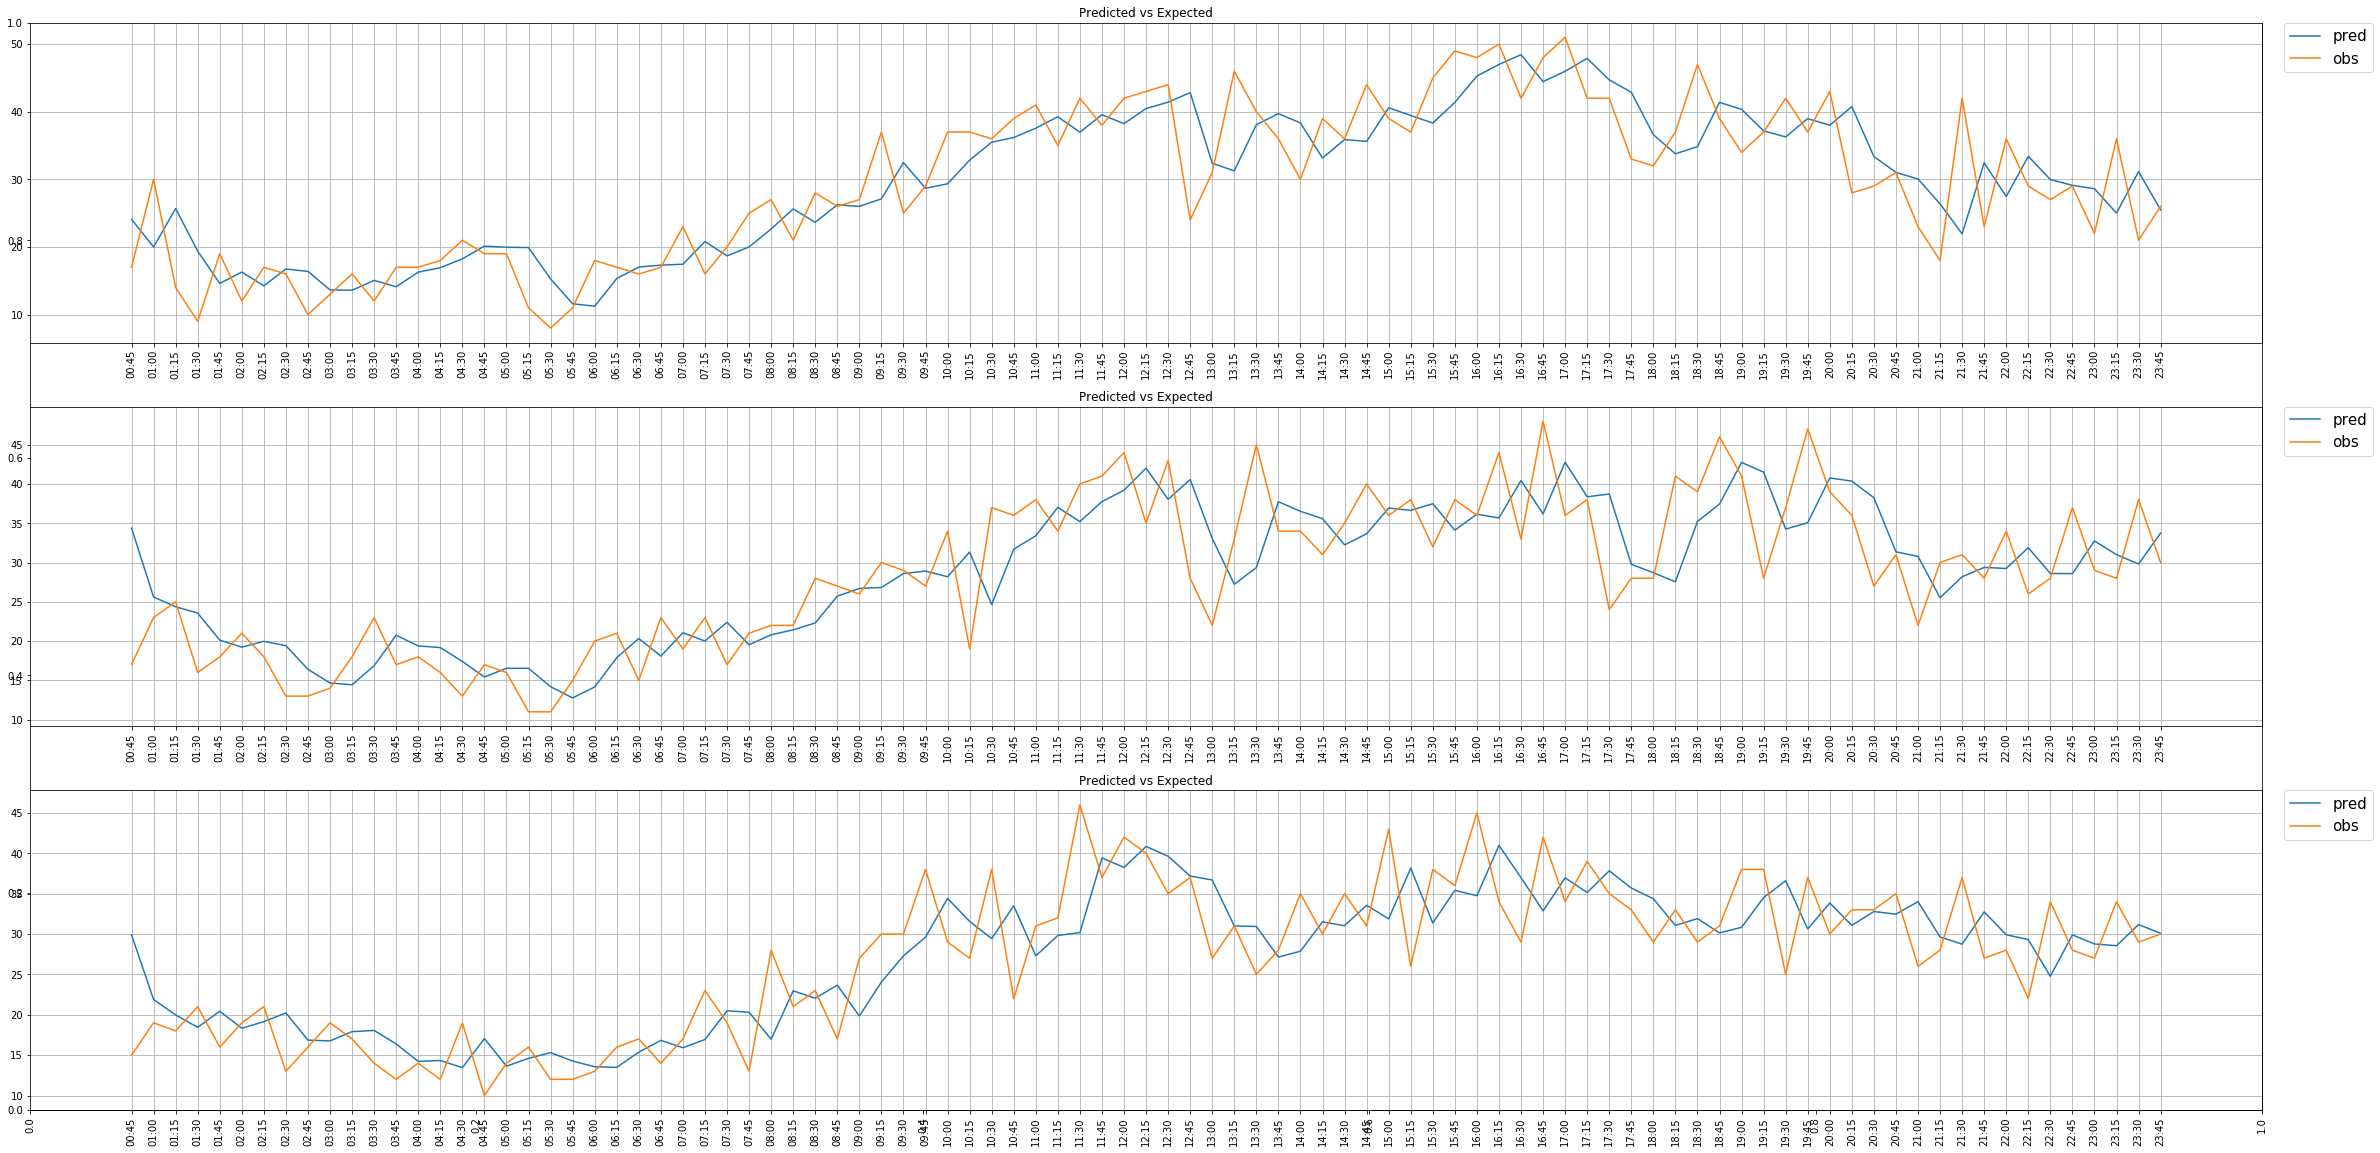

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
curr_dir = os.getcwd()


obs_df = pd.read_csv('3day_unsmoothed.csv')
obs = obs_df.values
obs = obs.astype('float32')

obsX, obsY = create_dataset(obs)
#print(obsX)
pred = model.predict(obsX)
#print(pred)
#print(obsY)

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 45), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]
print(len(pred[93:186]))
print(len(pred[186:279]))

#sys.exit()
#Esta feito para um gráfico ao longo de três dias 
def plot_results(dts, pred, obsY, plot_name):
    fig = plt.figure(1)
    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(dts,pred[0:93], label="pred")
    ax.plot(dts,obsY[0:93], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax2 = fig.add_subplot(312)
    ax2.plot(dts, pred[93:186], label="pred")
    ax2.plot(dts,obsY[93:186], label="obs")
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax2.grid(True)
    ax2.set_title("Predicted vs Expected")
    ax2.tick_params(axis='x', rotation=90)

    ax3 = fig.add_subplot(313)
    ax3.plot(dts, pred[186:279], label="pred")
    ax3.plot(dts,obsY[186:279], label="obs")
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax3.grid(True)
    ax3.set_title("Predicted vs Expected")
    ax3.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\results_nn\\" +str(plot_name)+".png", dpi=100)
plot_results(dts, pred, obsY, "linear_reg")
#plot_changes(test, df_test)

In [40]:
#smoothing using z_score
#not great
from scipy import stats

import numpy as np

date = copy.deepcopy(train2.iloc[:,0])
values = copy.deepcopy(train2.iloc[:,1:])
cenas = values.values

z = np.abs(stats.zscore(values))
y = np.abs(stats.zscore(cenas))
threshold = 2
z_score = np.where(y > 3)
#print(cenas[1])
#print(cenas[1,-2])
#print(train2.columns[9])
#z_score doesnt really work very well
for i in z_score[0]:
    for j in z_score[1]:
        #dois casos especiais : 0h00 e 23h45
        if j == 0:
            #values.columns[j] == "0h00":
            #dostuff
            previous_t = cenas[i,-1]
            
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
        if j == 95:
            #dostuff
            next_t = cenas[i,0]
            previous_t = cenas[i,j-1]
            cenas[i,j] = (previous_t + next_t)/2
        else:
            previous_t = cenas[i,j-1]
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
            #values.loc[i,values.columns[j]] = (previous_t + next_t)/2


Text(0.5, 1.0, 'CEnAS')

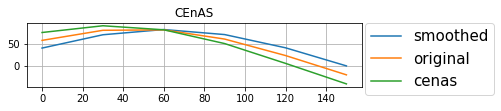

In [2]:
#print(dt2.head(10))
# split into train and test sets
#train_size = int(len(dt2) * 0.8)
#test_size = len(dt2) - train_size
#train, test = dt2[0:train_size,:], dt2[train_size:len(dt2),:]


#train2 = copy.deepcopy(train)
#for column in dt2:
#    if column == "Data":
#        continue
#    else:
#        mean = dt2[column].mean()
#        stdev = dt2[column].std()
#        dt2.loc[dt2[column] > (mean + 2*stdev), column] = mean
        
    
#train_size = int(len(dataset) * 0.8)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# split into train and test sets

#print(layer2.get_weights())